<a href="https://colab.research.google.com/github/tomorrownow/intro-to-geoprocessing-workshop/blob/main/geoprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to Geoprocessing with the GRASS GIS Geoprocessing Engine

This notebook is an introduction to geoprocessing with [GRASS GIS](https://grass.osgeo.org). We aim to introduce you to the basics concepts of Geographic Information Systems (GIS) and how to use GRASS GIS to perform geoprocessing tasks.


<!-- ![Fun image](./images/flooding_background.png) -->

## What is GIS?  
GIS is a system designed to capture, store, manipulate, analyze, manage, and present spatial or geographic data. GIS applications are tools that allow users to create interactive queries (user-created searches), analyze spatial information, edit data in maps, and present the results of all these operations.

There are many GIS software solutions that each perform well at differnt tasks.

The two most widely GIS desktop solutions are.

- ArcGIS Pro (Proprietary)
- QGIS (Open Source)

GRASS GIS can be used as a desktop GIS solution, but it really thrives as a **geospatial processing engine**.

## What is a Geospatial Processing Engine?

A geospatial processing engine is a tool that allows to efficiently manipulate geospatial data through the development of scriptable geoprocesing workflows. Geoprocessing engines can be used on a local machine, distributed on the cloud, or on HPC (high performance computing) clusters (i.e., super computers).

With GRASS you can effiently process geospatial data with over 800 tools or develop your own models or tools using its C and Python APIs.

The tools are prefixed to reflect the type of data they are designe to work with.

* d.* - display commands for graphical screen output: d.rast, d.vect, d.sites, d.mon
* g.* - general file management commands: g.list, g.copy
* i.* - image processing commands
* r.* - raster processing commands: r.slope.aspect, r.mapcalc
* v.* - vector processing commands: v.digit, v.to.rast
* db.* - dabase commands: db.selet
* r3.* - 3d raster
* t.* - temporal
* m.* - Miscellaneous

In [ ]:
from IPython.display import IFrame

# URL of the website to be embedded
url = 'https://earth.nullschool.net/'

# Dimensions of the IFrame
width = 800
height = 600

# Display the IFrame in the notebook
IFrame(url, width=width, height=height)

## Let's Jump in

![deepend.webp](./images/deepend.webp)

### Install GRASS GIS

In [ ]:
%%bash

apt-get install grass grass-dev grass-doc
# leave the directory with source code
cd ~

# download sample data
mkdir -p grassdata
mkdir -p output
curl -SL https://grass.osgeo.org/sampledata/north_carolina/nc_basic_spm_grass7.zip > nc_basic_spm_grass7.zip
unzip -qq nc_basic_spm_grass7.zip
mv nc_basic_spm_grass7 grassdata
rm nc_basic_spm_grass7.zip

curl -SL https://storage.googleapis.com/public_grassdata/ncssm_workshop_data/ncssm.zip > ncssm.zip
unzip -qq ncssm.zip
mv ncssm grassdata/nc_basic_spm_grass7
rm ncssm.zip


In [ ]:
import os
os.chdir(os.path.expanduser("~"))

### Create a GRASS Project

A project in GRASS is called a `Location`. Each location has subprojects called `Mapsets`. A mapset is a directory containing maps, which are the basic data layer in GRASS.

In [ ]:
# ! means that we are running a command in the shell
!grass -e -c ./grassdata/nc_basic_spm_grass7/tutorial

In [29]:
import os
import subprocess
import sys
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from pprint import pprint
from PIL import Image 
import pandas as pd
import sqlite3


# Ask GRASS GIS where its Python packages are.
gisbase = subprocess.check_output(["grass", "--config", "path"], text=True).strip()
os.environ["GISBASE"] = gisbase
print(gisbase)

# Ask GRASS GIS where its Python packages are.
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)

# Import the GRASS GIS packages we need.
import grass.script as gs

# Import GRASS Jupyter
import grass.jupyter as gj


# Start GRASS Session
## Set your grass data location
gj.init("./grassdata/nc_basic_spm_grass7/tutorial")

# Install Add-Ons
gs.run_command("g.extension", extension="d.region.grid")

/usr/local/grass83
Your branch is up to date with 'origin/grass8'.


![grassdata](./images/grass_database.png)
[Learn More](https://grass.osgeo.org/grass83/manuals/grass_database.html)

## Geospatial data?

Geospatial data is data that is associated with a particular location on the surface of the Earth. This data can be represented in many forms, such as points, lines, polygons, and rasters. Geospatial data can be used to answer questions such as "Where is the nearest hospital?" or "What is the average temperature in this region?".

### Coordinate Reference Systems (CRS)

Coordinate reference systems (CRS) are used to specify the location of a point on the Earth's surface. 

**Geodetic (Geographic) coordinate systems** are used to specify the location of a point on the Earth's surface using latitude and longitude (units degree:minutes:seconds).

Example:
- -78.0, 35.0 (Durham, NC)

Use Case:
- GPS coordinates
- Large regions
- Data Exchange

The most common CRS is the `WGS84`, which is used by GPS systems.

**Projected coordinate systems** are used to represent the Earth's surface on a flat map.

Projected coordinate systems are a type of CRS that is used to represent the Earth's surface on a flat map. Each version uses a different mathematical model to transform the Earth's three-dimensional surface into a two-dimensional plane. The choice of a projected coordinate system depends on the region of interest and the purpose of the map.

Example Developable Surfaces:
- Cylindrical
- Conic
- azimuthal

Types of distortion:
- Conformal
- Equal Area
- Equidistant

![projection](./images/crs_projected.jpg)

In North Carolina,`NAD83 North Carolina State Plane` (EPSG: 3358) is a commonly used projected coordinate system. It uses the `Lambert Conformal Conic` projection and has units of meters.
You can find other various of CRS at [epsg.io](https://epsg.io) that can be used for different regions of the world.


**Web Mapping & Pseudo-Mercator**

`Pseudo-Mercator` (EPSG: 3857) is a projected coordinate system that is used by web mapping services such as Google Maps, OpenStreetMap, and Bing Maps. It uses the `Mercator` projection and has units of meters.

Even though it is widely used for web mapping, it is not recommend for professional work because it has a high level of distortion at high latitudes and considers the Earth as a perfect sphere instead of an `geoid`.

You can see for yourself the distortion of the Mercator projection by using the [The true size](https://thetruesize.com) website.


**Learn More**
Learn more about [Map projection transitions](https://www.jasondavies.com/maps/transition)
Look up CRS at [epsg.io](https://epsg.io)

#### Coordinate Reference Systems in GRASS GIS

Every `project` (i.e., location) in GRASS GIS has a CRS. You can view the CRS of a `project` using the `g.proj` module.

We are currently in the `nc_basic_spm_grass7` project, which uses the `NAD83 / North Carolina (meters)` coordinate reference system (EPSG:3358).

We set the `project` using the using the following command:

```python

gj.init("./grassdata", "nc_basic_spm_grass7", "tutorial")

```

You can use either Python or the GRASS GIS command line look at the details of the `project` CRS.

**Python:**

```python

gs.read_command("g.proj", flags="p")

```

**GRASS GIS Command Line:**

```bash
g.proj -p
```

In [ ]:
# URL of the website to be embedded
url = 'https://www.jasondavies.com/maps/transition'

# Dimensions of the IFrame
width = 1000
height = 800

# Display the IFrame in the notebook
IFrame(url, width=width, height=height)

Atalantis Projection (Ocean Currents)

In [ ]:
from IPython.display import IFrame

# URL of the website to be embedded
url = 'https://earth.nullschool.net/#current/ocean/primary/waves/overlay=currents/atlantis'

# Dimensions of the IFrame
width = 800
height = 600

# Display the IFrame in the notebook
IFrame(url, width=width, height=height)

Lets execute the command to see the details of the `project` CRS using both python and the shell.

In [ ]:
# This code is written in python and uses the GRASS Jupyter library

gj.init("./grassdata", "nc_basic_spm_grass7", "tutorial")
gs.parse_command("g.proj", flags="p")

In [ ]:
# This code is running a GRASS GIS command in the shell
!g.proj -p

### Vector Data

Vector data is represented as points, lines, and polygons on a map. Points are used to represent specific locations, such as the location of a tree or a building. Lines are used to represent linear features, such as roads or rivers. Polygons are used to represent areas, such as the boundaries of a city or a forest.

We will use the [g.list](https://grass.osgeo.org/grass83/manuals/g.list.html) command from GRASS GIS to view avaliable vector data by filtering the results with `type=vector`.

In [ ]:
!g.list type=vector

Vector data have attribute tables that contain information about the features, such as the name of a city or the population of a country.

Let's look at what the attribute table column names and data types are for the `firestations` layer.

To do this we will use the [v.info -c](https://grass.osgeo.org/grass83/manuals/v.info.html) command from GRASS GIS.

In [ ]:
!v.info -c firestations

We can now view the attribute data as a `dataframe` using the [pandas](https://pandas.pydata.org) python library. 

To accomplish this we will copy the `firestations` vector layer to our `subproject` (i.e., mapset) to work with.

In [ ]:
# Make a copy of the firestations vector to your current mapset called myfirestations
gs.run_command("g.copy", vector="firestations,myfirestations")

Vector attribute data in GRASS is store in a [sqlite](https://www.sqlite.org) database by default. \
To access the data through the Jupyter notebook we must first get the connection string to the database using GRASS's [db.databases](https://grass.osgeo.org/grass83/manuals/db.databases.html) command.

In [ ]:
# Connect to the SQLite database
sqlpath = gs.read_command("db.databases", driver="sqlite").replace('\n', '')

We can then connect to the [sqlite](https://www.sqlite.org) database using the path and the [sqlite3](https://docs.python.org/3/library/sqlite3.html) python package.

In [ ]:
# Connect to the database
con = sqlite3.connect(sqlpath)

Now that we are connected to the database we can write a SQL query to `SELECT` all columns (i.e. `*`) `FROM` our `myfirestations` vector layers attribute table `WHRERE` the `rows` with the column `CITY` has the value of `Raleigh`

In [ ]:
# Query the database for the myfirestations table
sqlstat="SELECT * FROM myfirestations WHERE CITY = 'Raleigh'"

Now we can use `pandas` to read our attribute data from the database into a `dataframe`.

In [ ]:
# Create a pandas dataframe from the SQL query
df_firestations = pd.read_sql_query(sqlstat, con)

# Close the connection to the database
con.close()

Now we can view our attribute data from our `dataframe` stored as the python variable `df_firestations`.

In [ ]:
# Display the first few rows of the dataframe
df_firestations.head() # Default is 5 rows 

We can now use any other python plotting tool to charts from our attribute data.

References:
* [Matplotlib](https://matplotlib.org/stable/users/explain/quick_start.html)
* [Pandas](https://pandas.pydata.org/docs/user_guide/visualization.html)
* [Seaborn](https://seaborn.pydata.org/examples/index.html)



In [ ]:
# Creates a horizontal bar chart of showing the number of pumper tanks at each fire station in Raleigh, NC 
(df_firestations
    .sort_values('PUMPERS', ascending=True)
    .plot.barh(
        x='LABEL',
        y='PUMPERS',
        label="Pumpers per Station",
        title="Pumpers per Station",
        figsize=(10, 6),
        color='blue'
    ))
plt.xlabel("Number of Pumpers")
plt.ylabel("Fire Stations")
plt.show()


#### Visualizing Vector Data

Using [GRASS Jupyter](https://grass.osgeo.org/grass83/manuals/libpython/grass.jupyter.html) imported as `gj` we can display vector data in our notebook.

In this example we will make a make of `zipcodes` in Wake County (i.e., polygon), with `roadsmajor` (i.e., line), and our `firestations` (i.e., point).

In [ ]:
# Create a new map object
vect_map = gj.Map()

# Add the vector map to the map object
vect_map.d_vect(map="zipcodes", fill_color="grey", color="black", width=2)
vect_map.d_vect(map="roadsmajor", fill_color="grey", color="white", width=1)

# Add the firestations point vector map to the map as a thematic map
vect_map.d_vect_thematic(
    map="firestations",
    column="PUMPERS",
    algorithm="qua",
    size=10,
    nclasses=3,
    where="CITY = 'Raleigh'",
    icon="basic/circle",
    colors="0:195:176,251:253:0,242:127:11",
)

# Add a legend to the map
vect_map.d_legend_vect(
    at=(80, 95),
    flags="b"
)

# Add a scale bar to the map with the north arrow
vect_map.d_barscale(at=(70,10), flags="n")

# Display the map
vect_map.show()

### Rasters Data

Raster are a way of represent `continuous` or `discrete` spatial data  in a grid format. Each cell in the grid has a value that represents a particular attribute. For example, a raster could represent the temperature of the Earth's surface, with each cell representing the temperature at a particular location.

Let's look at what raster data is avaliable to use in our `project`.

In [ ]:
# Use the d.rast command to display the elevation raster map from the shell
!g.list type=raster

Our `project` has 7 available raster datasets for us to examine.

#### Setting the Region

We are going to set the region to the extent of the `elevatioin` raster data we are going to use. The `elevation` raster data is a Digital Elevation Model (DEM) of the area around Wake County, North Carolina.

In [30]:
region = gs.read_command("g.region", raster="elevation", flags="p")
print(region)

projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      228500
south:      215000
west:       630000
east:       645000
nsres:      10
ewres:      10
rows:       1350
cols:       1500
cells:      2025000



Let's first map our the `elevation` raster for the `nc_basic_spm_grass7` project.

In [ ]:
# Create a map object
dem_map = gj.Map()

# Add the raster map to the map object
dem_map.d_rast(map="elevation")

# Add the vector map to the map object
dem_map.d_vect(map="roadsmajor", color="black")

# Add a legend to the mapProrietry
dem_map.d_legend(raster="elevation", at=(5,40,5,9), flags="b", title="Elevation (m)")

# Add a scale bar to the map
dem_map.d_barscale(at=(50,7), flags="n")

# Display the map
dem_map.show()

In [ ]:
!r.info elevation

Is the `elevation` raster `continuous` or `discrete`? 

Now lets examine the `landuse` raster by mapping it.

In [ ]:
# Create a map object
dem_map = gj.Map()

# Add the raster map to the map object
dem_map.d_rast(map="landuse")

# Add the vector map to the map object
dem_map.d_vect(map="roadsmajor", color="black")

# Add a legend to the mapProrietry
dem_map.d_legend(raster="landuse", at=(5,40,5,9), flags="b", title="Landuse")

# Add a scale bar to the map
dem_map.d_barscale(at=(50,7), flags="n")

# Display the map
dem_map.show()

In [ ]:
!r.info landuse

Is the `landuse` raster `continuous` or `discrete`? 

#### Spatial Temporal Scale

Spatial scale reprents the resolution (i.e., grain) of each pixel and the total extent (i.e., area) of the raster. The temporal scale represents the time period (i.e., extent) and the frequency (i.e., grain) of the data collection.

As shown above the `elevation` raster layer has a spatial resoution of 10m. This means that each cell has a dimension of 10m x 10m or $100m^2$. The `elevation` raster layer has a spatial extent of 1,350 rows x 1,500 columns which make up 202,500 cells representing an area of $20,250,000m^2$ or $20.25km^2$.

The `landuse` raster has a spatial resolution of 28.5m, which means each cell is $812.25m^2$ and the raster represents a total of 249,324 cells or $20.25km^2$.

**Computational Region:**

In GRASS GIS the `region` or `computational region` defines the spatial temporal scale. 

The computational region you select will impact your analytical results and the ammount of time it takes to process data.

Raster data is createed at a specific spatail resolution and extent, but you can change the spatial resolution through the process of resampling (upscaling, downscaling).

**1D and 2D Interpolation**

With raster data we can use 2D interpolation to resample our data.

> Note: We use different methods for `continuous` and `discrete` spatial data.

![Interpolation](./images/interpolation.png)
[Source: Cmglee](https://en.wikipedia.org/wiki/Bilinear_interpolation#/media/File:Comparison_of_1D_and_2D_interpolation.svg)

Let [resample](https://grass.osgeo.org/grass83/manuals/r.resamp.interp.html) the `elevation` data using `bliniear` interpolation so that each cell spatial resolution is `250m, 500m, and 1000m` to see the effect that spatial resolution has on our evelation data.



> Will resampling the data change the `spatial extent` of the data?

In [31]:
%%bash

# Set the computational region to 250m and align the grid to the evelvation raster
g.region raster=elevation res=250 -pa

# Interpolate the elevation raster from 10m to 250m using bilinear interpolation
r.resamp.interp elevation out=elevation250m method=bilinear

g.region raster=elevation res=500 -pa
r.resamp.interp elevation out=elevation500m method=bilinear

g.region raster=elevation res=1000 -pa
r.resamp.interp elevation out=elevation1000m method=bilinear

# Reset the computational region to the original elevation raster
g.region raster=elevation res=10 -p

projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      228500
south:      215000
west:       630000
east:       645000
nsres:      250
ewres:      250
rows:       54
cols:       60
cells:      3240


   0   3   7  11  14  18  22  25  29  33  37  40  44  48  51  55  59  62  66  70  74  77  81  85  88  92  96 100


projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      228500
south:      215000
west:       630000
east:       645000
nsres:      500
ewres:      500
rows:       27
cols:       30
cells:      810


   0   3   7  11  14  18  22  25  29  33  37  40  44  48  51  55  59  62  66  70  74  77  81  85  88  92  96 100


projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      229000
south:      215000
west:       630000
east:       645000
nsres:      1000
ewres:      1000
rows:       14
cols:       15
cells:      210


   0   7  14  21  28  35  42  50  57  64  71  78  85  92 100


projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      228500
south:      215000
west:       630000
east:       645000
nsres:      10
ewres:      10
rows:       1350
cols:       1500
cells:      2025000


We can now show a map and the histogram of our interpolated elevation datasets.

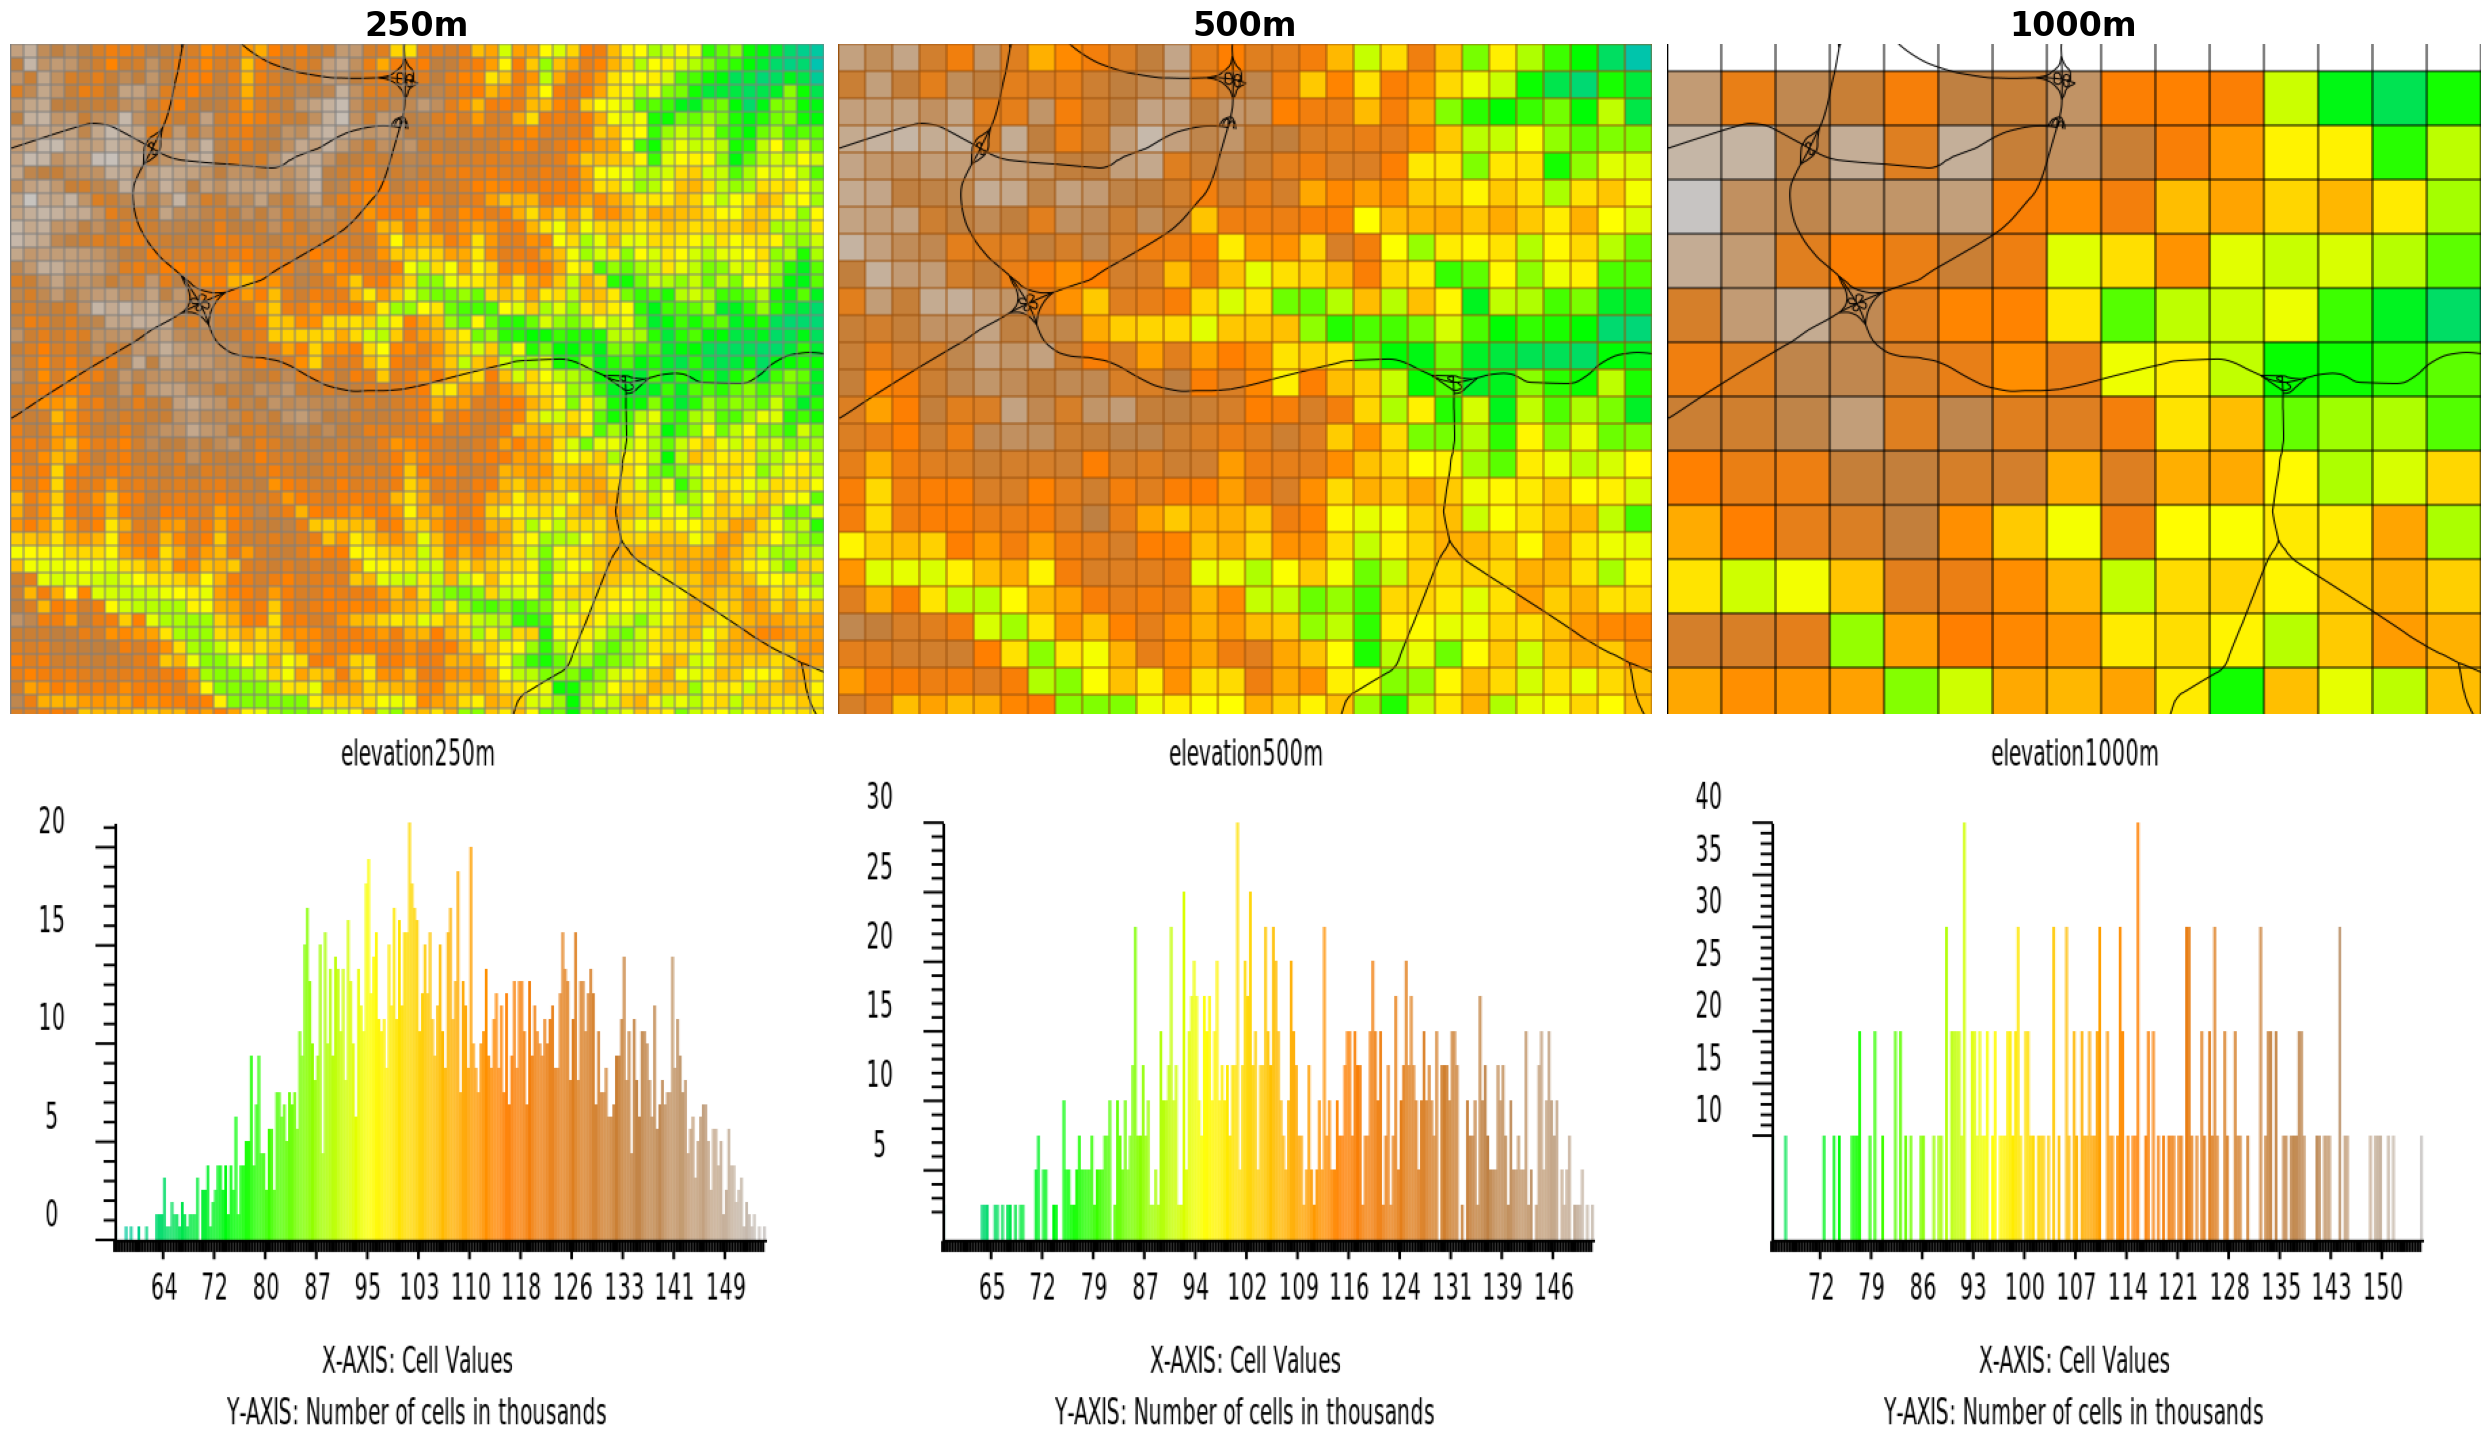

In [37]:
fig = plt.figure(figsize=(25, 30))


ax = fig.add_subplot(2, 3, 1)
fig.subplots_adjust(hspace=0, wspace=0.1)
ax.set_axis_off()
dem250_map = gj.Map(filename="output/dem250_map.png", use_region=True)
dem250_map.d_rast(map="elevation250m")
dem250_map.d_vect(map="roadsmajor", color="black")
dem250_map.d_region_grid(raster="elevation250m")
img1 = Image.open("output/dem250_map.png") 
plt.imshow(img1)
ax.set_title("250m", {"fontsize": 24, "fontweight": "bold"})

ax = fig.add_subplot(2, 3, 2)
ax.set_axis_off()
dem500_map = gj.Map(filename="output/dem500_map.png", use_region=True)
dem500_map.d_rast(map="elevation500m")
dem500_map.d_vect(map="roadsmajor", color="black")
dem500_map.d_region_grid(raster="elevation500m", color="#9B520D")
dem500_map.show()
img2 = Image.open("output/dem500_map.png")
plt.imshow(img2)
ax.set_title("500m", {"fontsize": 24, "fontweight": "bold"})


ax = fig.add_subplot(2, 3, 3)
ax.set_axis_off()
dem1000_map = gj.Map(filename="output/dem1000_map.png", use_region=True)
dem1000_map.d_rast(map="elevation1000m")
dem1000_map.d_vect(map="roadsmajor", color="black")
dem1000_map.d_region_grid(raster="elevation1000m", color="black")
dem1000_map.show()
img3 = Image.open("output/dem1000_map.png")
plt.imshow(img3)
ax.set_title("1000m", {"fontsize": 24, "fontweight": "bold"})


ax = fig.add_subplot(1, 3, 1)
fig.subplots_adjust(hspace=0, wspace=0.1)
ax.set_axis_off()
dem250_hist = gj.Map(filename="output/dem250_hist.png", use_region=True)
dem250_hist.d_histogram(map="elevation250m")
img4 = Image.open("output/dem250_hist.png") 
plt.imshow(img4)

ax = fig.add_subplot(1, 3, 2)
ax.set_axis_off()
dem500_hist = gj.Map(filename="output/dem500_hist.png", use_region=True)
dem500_hist.d_histogram(map="elevation500m")
dem500_hist.show()
img5 = Image.open("output/dem500_hist.png")
plt.imshow(img5)


ax = fig.add_subplot(1, 3, 3)
ax.set_axis_off()
dem1000_hist = gj.Map(filename="output/dem1000_hist.png", use_region=True)
dem1000_hist.d_histogram(map="elevation1000m")
dem1000_hist.show()
img6 = Image.open("output/dem1000_hist.png")
plt.imshow(img6)

plt.tight_layout()
plt.savefig("./images/dem_spatial_scale.png", bbox_inches="tight", dpi=300)

plt.show()


Let's look at what they look like all together.

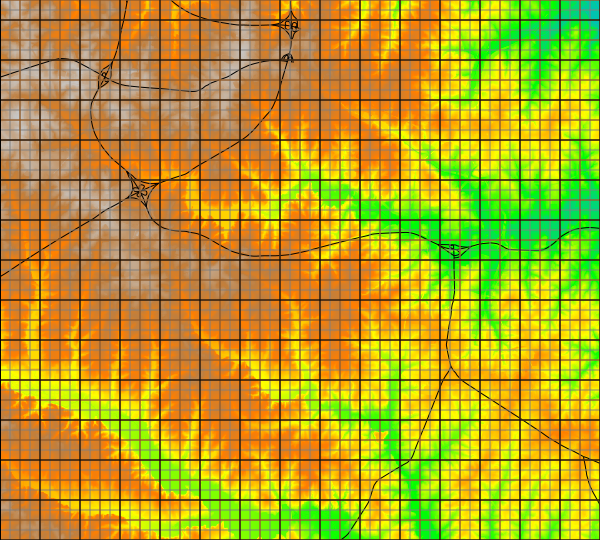

In [38]:
# Create the map object
dem_map = gj.Map(filename="./images/spatial_scale.png")

# Add the elevation raster to the map
dem_map.d_rast(map="elevation")

# Add the roads vector to the map and draw the lines black
dem_map.d_vect(map="roadsmajor", color="black")

# Draw a grid of the computational regions
dem_map.d_region_grid(raster="elevation250m")
dem_map.d_region_grid(raster="elevation500m", color="#9B520D")
dem_map.d_region_grid(raster="elevation1000m", color="black")

# Display the map
dem_map.show()

Let's now look at what happends when we resample `discete` raster data like `landuse`.

This time we will use a `python` function to simplify the workflow.

In [34]:
# Install r.boxplot add-on
gs.run_command("g.extension", extension="r.boxplot")

def discrete_resample(raster, resolutions):
    for res in resolutions:
        output = f"{raster}{res}m"
        output_int = f"{raster}{res}m_int"
        elevation=f"elevation{res}m"
        boxplot_output = f"output/{output}_bp.png"
        expression = f"{output_int} = int({output})"
        # Change the resolution of the computational region.
        gs.run_command("g.region", raster="elevation", res=res, flags="pa")
        gs.run_command("r.resamp.interp", input=raster, output=output, method="nearest")
        # Convert output to CELL (integer format)
        gs.run_command("r.mapcalc", expression=expression)
        gs.run_command("r.colors", map=output_int, raster=raster)
        gs.run_command("r.category", map=output_int, raster=raster)

        # Create a box plot
        gs.run_command("r.boxplot", input=elevation, zones=output_int, raster_statistics="median,IQR", output=boxplot_output, quiet=True, flags="c")

discrete_resample("landuse", [250, 500, 1000])
region = gs.read_command("g.region", raster="elevation", res=10, flags="pa")
print(region)

Your branch is up to date with 'origin/grass8'.
projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      228500
south:      215000
west:       630000
east:       645000
nsres:      250
ewres:      250
rows:       54
cols:       60
cells:      3240
projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      228500
south:      215000
west:       630000
east:       645000
nsres:      500
ewres:      500
rows:       27
cols:       30
cells:      810
projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      229000
south:      215000
west:       630000
east:       645000
nsres:      1000
ewres:      1000
rows:       14
cols:       15
cells:      210
projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:     

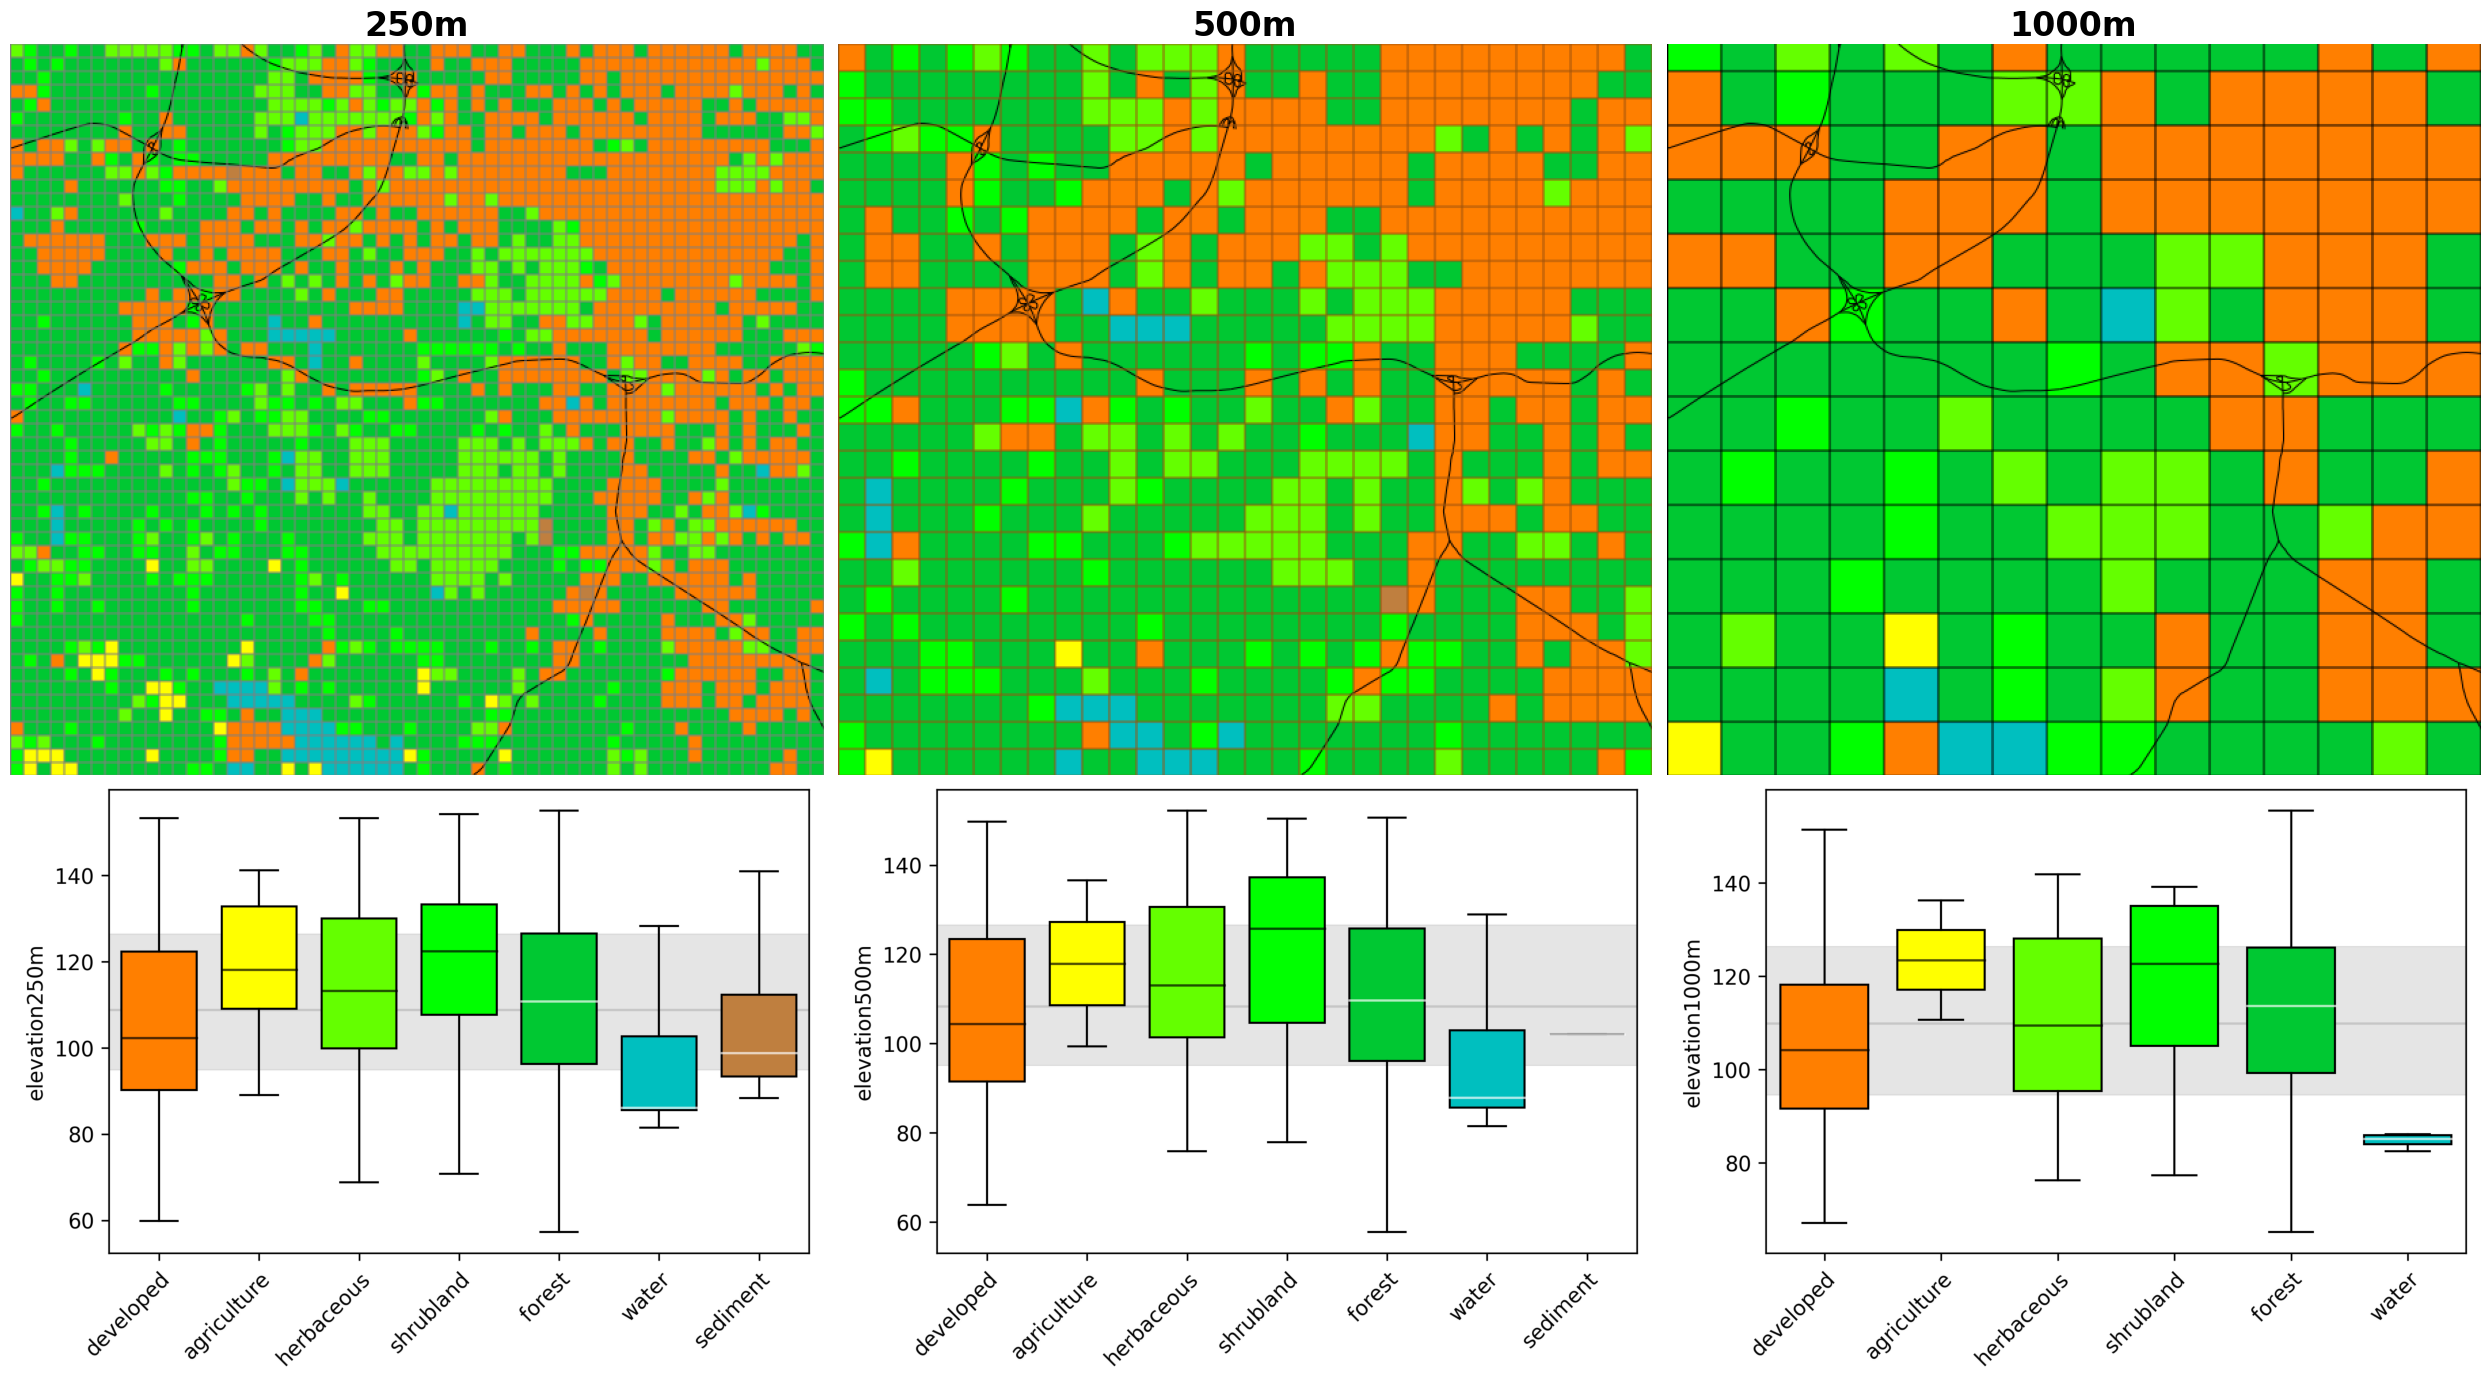

In [39]:
fig = plt.figure(figsize=(25, 30))
fig.subplots_adjust(hspace=0, wspace=0.1)



ax = fig.add_subplot(2, 3, 1)
ax.set_axis_off()
landuse250_map = gj.Map(filename="output/landuse250_map.png", use_region=True)
landuse250_map.d_rast(map="landuse250m")
landuse250_map.d_vect(map="roadsmajor", color="black")
landuse250_map.d_region_grid(raster="landuse250m")
img1 = Image.open("output/landuse250_map.png") 
plt.imshow(img1)
ax.set_title("250m", {"fontsize": 24, "fontweight": "bold"})

ax = fig.add_subplot(2, 3, 2)
ax.set_axis_off()
landuse500_map = gj.Map(filename="output/landuse500_map.png", use_region=True)
landuse500_map.d_rast(map="landuse500m")
landuse500_map.d_vect(map="roadsmajor", color="black")
landuse500_map.d_region_grid(raster="landuse500m", color="#9B520D")
landuse500_map.show()
img2 = Image.open("output/landuse500_map.png")
plt.imshow(img2)
ax.set_title("500m", {"fontsize": 24, "fontweight": "bold"})


ax = fig.add_subplot(2, 3, 3)
ax.set_axis_off()
landuse1000_map = gj.Map(filename="output/landuse1000_map.png", use_region=True)
landuse1000_map.d_rast(map="landuse1000m")
landuse1000_map.d_vect(map="roadsmajor", color="black")
landuse1000_map.d_region_grid(raster="landuse1000m", color="black")
landuse1000_map.show()
img3 = Image.open("output/landuse1000_map.png")
plt.imshow(img3)
ax.set_title("1000m", {"fontsize": 24, "fontweight": "bold"})


ax = fig.add_subplot(1, 3, 1)
fig.subplots_adjust(hspace=0, wspace=0.1)
ax.set_axis_off()
img4 = Image.open("output/landuse250m_bp.png") 
plt.imshow(img4)

ax = fig.add_subplot(1, 3, 2)
ax.set_axis_off()
img5 = Image.open("output/landuse500m_bp.png")
plt.imshow(img5)


ax = fig.add_subplot(1, 3, 3)
ax.set_axis_off()
img6 = Image.open("output/landuse1000m_bp.png")
plt.imshow(img6)

plt.tight_layout()
plt.savefig("./images/lc_spatial_scale.png", bbox_inches="tight", dpi=300)

plt.show()

### Date Visualization

#### Static Map

In [ ]:
dem_map = gj.Map()

dem_map.d_rast(map="elevation")
dem_map.d_vect(map="roadsmajor", color="black")
dem_map.d_legend(raster="elevation", at=(2,50,2,9))
dem_map.d_vect(map="roadsmajor", color="black")
dem_map.show()

#### Histogram

In [ ]:
dem_hist = gj.Map()
dem_hist.d_histogram(map="elevation")
dem_hist.show()

#### Shaded Relief

Let's calcuate our aspect map to use for our relief map

In [ ]:
gs.run_command(
    "r.slope.aspect",
    elevation="elevation",
    slope="slope",
    aspect="aspect",
    dx="dx",
    dy="dy",
    overwrite=True
)

##### Aspect

Aspect shows the direction (e.g., n, e, s, w)

In [ ]:
aspect_map = gj.Map()
aspect_map.d_rast(map="aspect")
aspect_map.show()

#### Shaded Releif Map

In [ ]:
dem_map = gj.Map()
dem_map.d_shade(color="elevation", shade="aspect")
dem_map.d_legend(raster="elevation", at=(5,50,5,9), flags="b")
dem_map.d_barscale(at=(50,7,1,1), flags="n")
dem_map.show()

#### Visualize Data in 3D

In [ ]:
elevation_3dmap = gj.Map3D()
# Full list of options m.nviz.image
# https://grass.osgeo.org/grass83/manuals/m.nviz.image.html
elevation_3dmap.render(
    elevation_map="elevation",
    color_map="elevation",
    perspective=20,
    height=3000,
    vline="roadsmajor",
    vline_color="blue",
    vpoint="hospitals",
    vpoint_color="red",
    vpoint_marker="basic/circle",
    vpoint_size=200,
    fringe=['ne','nw','sw','se'],
    arrow_position=[100,50],
)
elevation_3dmap.overlay.d_legend(raster="elevation", at=(60, 97, 87, 92))
elevation_3dmap.show()

#### Interactive Maps

In [ ]:
elevation_map = gj.InteractiveMap()
elevation_map.add_raster("elevation")
elevation_map.show()

### Watershed Analysis

In [ ]:
gs.run_command("r.watershed", 
               elevation="elevation", 
               threshold=10000,
               accumulation="accum10k",
               drainage="direction10k",
               basin="basins10k", 
               stream="streams10k", 
               memory=300
            )

In [ ]:
accum10k_map = gj.Map()
accum10k_map.d_rast(map="basins10k")
accum10k_map.d_shade(color="basins10k", shade="aspect")
accum10k_map.d_barscale(at=(50,7,1,1), flags="n")
accum10k_map.show()

### Create a new Project (Location and Mapset)

### Importing Data

### Where can I get my own geospatial data?

#### North Carolina Online Data Portals

* [NC OneMap](https://www.nconemap.gov/)
* [Durham OpenData Portal](https://live-durhamnc.opendata.arcgis.com/)

In [ ]:
# Point Data
hospitals = "https://webgis2.durhamnc.gov/server/rest/services/PublicServices/Community/MapServer/0/query?outFields=*&where=1%3D1"
schools = "https://webgis2.durhamnc.gov/server/rest/services/PublicServices/Education/MapServer/0/query?outFields=*&where=1%3D1&f=geojson"

# Line Data
roads = "https://webgis2.durhamnc.gov/server/rest/services/PublicServices/Transportation/MapServer/6/query?outFields=*&where=1%3D1"
greenways = "https://webgis2.durhamnc.gov/server/rest/services/ProjectServices/Trans_ExistingFutureBikePedFacilities/MapServer/1/query?outFields=*&where=1%3D1"
sidewalks = "https://webgis2.durhamnc.gov/server/rest/services/PublicServices/Community/MapServer/5/query?outFields=*&where=1%3D1"

# Polygon Datahttps://earth.nullschool.net
zipcodes = "https://webgis2.durhamnc.gov/server/rest/services/PublicServices/Administrative/MapServer/0/query?outFields=*&where=1%3D1"
county_boundary = "https://webgis2.durhamnc.gov/server/rest/services/PublicServices/Administrative/MapServer/2/query?outFields=*&where=1%3D1"
durham_city_boundary = "https://webgis2.durhamnc.gov/server/rest/services/PublicServices/Administrative/MapServer/1/query?outFields=*&where=1%3D1"
school_districts = "https://webgis2.durhamnc.gov/server/rest/services/PublicServices/Education/MapServer/1/query?outFields=*&where=1%3D1"
ncssm = "https://services2.arcgis.com/G5vR3cOjh6g2Ed8E/arcgis/rest/services/Parcels/FeatureServer/0/query?outFields=*&where=OBJECTID%3D5653314&f=geojson"

In [ ]:
gs.run_command("v.import",
            input=ncssm,
            layer="OGRGeoJSON",
            extent="input",
            output="ncssm",
            overwrite=True
)

In [ ]:
gs.run_command("g.region", raster="ncssm_ql2_3m", res=3, flags="ap")
gs.run_command("r.colors", map="ncssm_ql2_3m", color="elevation")
map = gj.Map()
map.d_rast(map="ncssm_ql2_3m")
map.d_vect(map="ncssm")
map.d_legend(raster="ncssm_ql2_3m", at=(5,70,2,9))
map.d_barscale(at=(50fringe_elevation,20,1,2), flags="n")
map.show()

In [ ]:
elevation_3dmap = gj.Map3D()
# Full list of options m.nviz.image
# https://grass.osgeo.org/grass83/manuals/m.nviz.image.html
elevation_3dmap.render(
    elevation_map="ncssm_ql2_3m",
    color_map="ncssm_ql2_3m",
    perspective=20,
    height=4000,
    # vline="roadsmajor",
    # vline_color="bluuse_regione",
    resolution_fine=1,
    vpoint="schools",
    vpoint_color="red",
    vpoint_marker="sphere",
    vpoint_size=200,
    fringe=['ne','nw','sw','se'],
    arrow_position=[100,50],
)
elevation_3dmap.overlay.d_legend(raster="ncssm_ql2_3m", at=(60, 97, 87, 92))
elevation_3dmap.show()

## Import bare earth lidar data

In [ ]:
gs.run_command("g.region", res=1, flags="ap")
gs.run_command("v.in.pdal",
               input="./data/175003_1.las",
               output="ncssm_lidar_be_pts",
               flags="w",
               class_filter="2,13",
               overwrite=True
        )

### Interpolate Data to 1m DTM

In [ ]:
gs.run_command("g.region", raster="ncssm_ql2_3m", res=1, flags="ap")
gs.run_command("v.surf.rst", 
               input="ncssm_lidar_be_pts", 
               elevation="ncssm_be_1m",
               mask="ncssm_ql2_3m",
               tension=10,
               smooth=0.5,
               nprocs=25,
               overwrite=True
              )

In [ ]:
gs.run_command("r.colors", map="ncssm_be_1m", color="elevation")

elevation_3dmap = gj.Map3D()
# Full list of options m.nviz.image
# https://grass.osgeo.org/grass83/manuals/m.nviz.image.html
elevation_3dmap.render(
    elevation_map="ncssm_be_1m",
    color_map="ncssm_be_1m",
    perspective=20,
    height=4000,
    fringe=['ne','nw','sw','se'],
    arrow_position=[100,50],
)
elevation_3dmap.overlay.d_legend(raster="ncssm_be_1m", at=(60, 97, 87, 92))
elevation_3dmap.show()

## Import lidar data

In [ ]:
gs.run_command("v.in.pdal",
               input="./data/175003_1.las",
               output="ncssm_lidar_pts",
               flags="w",
               overwrite=True
        )

In [ ]:
!v.info ncssm_lidar_lr_pts

## Remove outliers

In [ ]:
!v.outlier input=ncssm_lidar_pts output=ncssm_lidar_pts_clean outlier=ncssm_lidar_pts_pts_outliers threshold=25

### Interpolate Data to 1m DTM

In [ ]:
gs.run_command("g.region", raster="ncssm_ql2_3m", res=1, flags="ap")
gs.run_command("v.surf.rst", 
               input="ncssm_lidar_pts_clean", 
               elevation="ncssm_1m",
               mask="ncssm_ql2_3m",
               tension=40,
               smooth=0.5,
               nprocs=25,
               overwrite=True
              )

In [ ]:
gs.run_command("g.region", vector="ncssm", res=1, align="ncssm_1m", flags="p")
colormap = gj.Map(r.random input=landclass96 npoints=1000 raster=training_pixels)
map.d_rast(map="ncssm_1m")
map.d_legend(raster="ncssm_1m", at=(5,70,2,9))
map.d_barscale(at=(50,20,1,2), flags="n")
map.show()

In [ ]:
elevation_3dmap = gj.Map3D(use_region=False)
# Full list of options m.nviz.image
# https://grass.osgeo.org/grass83/manuals/m.nviz.image.html
elevation_3dmap.render(
    elevation_map="ncssm_1m",
    color_map="ncssm_1m",
    perspective=20,
    height=3000,
    resolution_fine=1,
    # vline="roadsmajor",
    # vline_color="blue",
    # vpoint="hospitals",
    # vpoint_color="red",
    # vpoint_marker="sphere",
    # vpoint_size=200,
    zexag=1,
    fringe=['ne','nw','sw','se'],
    fringe_elevation=10,
    arrow_position=[100,50],
)
elevation_3dmap.overlay.d_legend(raster="ncssm_1m", at=(60, 97, 87, 92))
elevation_3dmap.show()

In [ ]:
gs.run_command("g.region", raster="ncssm_1m", res=1, flags="ap")

gs.run_command(
    "r.slope.aspect",
    elevation="ncssm_1m",
    # slope="ncssm_1m_slope",
    aspect="ncssm_1m_aspect",
    # dx="dx",
    # dy="dy",
    overwrite=True
)

dem_map = gj.Map()
dem_map.d_shade(color="ncssm_1m", shade="ncssm_1m_aspect")
dem_map.d_legend(raster="ncssm_1m", at=(5,50,5,9), flags="b")
dem_map.d_barscale(at=(50,7,1,1), flags="n")
dem_map.show()

In [ ]:
gs.run_command("g.extension", extension="r.sun.daily")

In [ ]:
!r.sun.daily elevation=ncssm_1m start_day=1 end_day=365 day_step=1 beam_rad_basename=beam beam_rad=beam_sum insol_time=insol_time_sum insol_time_basename=insol_time nprocs=4 -t
!t.rast.mapcalc input=insol_time output=shadow basename=shadow expression='if(isnull(insol_time), 1, null())' 

In [ ]:
beam_ts_map = gj.TimeSeriesMap(height=600, width=600)
OnsOnsOnsOnsbeam_ts_map.add_raster_series("insol_time")
beam_ts_map.d_legend(raster="insol_time_sum", title="Wh.m-2.day-1")
beam_ts_map.render()
beam_ts_map.save("./output/shadow_ts_map.gif")
beam_ts_map.show()

In [ ]:
gs.run_command("g.region", raster="ncssm_ql2_3m", res=1, flags="ap")
!r.composite blue=nc_m_3607857_se_17_060_20220914.m_3607857_se_17_060_20220914.2 green=nc_m_3607857_se_17_060_20220914.m_3607857_se_17_060_20220914.3 red=nc_m_3607857_se_17_060_20220914.m_3607857_se_17_060_20220914.1 output=naip_2022_rgb

In [ ]:
dem_map = gj.Map()
dem_map.d_rast(map="OnsOns")
dem_map.d_barscale(at=(50,7,1,1), flags="n")
dem_map.show()

In [ ]:
!i.vi red=nc_m_3607857_se_17_060_20220914.m_3607857_se_17_060_20220914.1 nir=nc_m_3607857_se_17_060_20220914.m_3607857_se_17_060_20220914.4 output=naip_ndvi_2022

In [ ]:
dem_map = gj.Map()
# dem_map.d_rast(map="naip_ndvi_2022")
dem_map.d_shade(color="naip_ndvi_2022", shade="ncssm_1m_aspect")
dem_map.d_legend(raster="naip_ndvi_2022", at=(5,50,5,9), flags="b")
dem_map.d_barscale(at=(50,7,1,1), flags="n")
dem_map.show()

In [ ]:
!i.vi red=nc_m_3607857_se_17_060_20200711.m_3607857_se_17_060_20200711.1 nir=nc_m_3607857_se_17_060_20200711.m_3607857_se_17_060_20200711.4 output=naip_ndvi_2020

In [ ]:
dem_map = gj.Map()
dem_map.d_shade(color="naip_ndvi_2020", shade="ncssm_1m_aspect")
dem_map.d_legend(raster="naip_ndvi_2020", at=(5,50,5,9), flags="b")
dem_map.d_barscale(at=(50,7,1,1), flags="n")
dem_map.show()

In [ ]:
# Convert NDVI to Manning's N
!r.mapcalc "mannings_n = if(naip_ndvi_2022 < 0.1, 0.15, if(naip_ndvi_2022 < 0.4, 0.1, 0.08))"

# Variable Rainfall in mm/hr
!r.mapcalc "rainfall = if(naip_ndvi_2022 < 0.1, 79.25, if(naip_ndvi_2022 < 0.4, 50.0, 10.0))"

In [ ]:
gs.run_command("g.region", raster="ncssm_be_1m", res=1, flags="ap")
# gs.run_command(
#     "r.slope.aspect",
#     elevation="ncssm_be_1m",
#     dx="dx",
#     dy="dy",
#     overwrite=True
# )

gs.run_command("r.sim.water",
               flags="t",
               elevation="ncssm_be_1m",
               dx="dx",
               dy="dy",
               # rain_value=50,
               infil_value=0,
               # man_value=0.05,
               depth="twdp",
               discharge="tdisch",
               nwalkers=100000,
               niterations=30, 
               output_step=2,
               rain="rainfall",
               man="mannings_n",
               nprocs=30,
               overwrite=True
              )

In [ ]:
gs.run_command(
    "t.create",
    output="tdepth_sum",
    type="strds",
    temporaltype="absolute",
    title="Runoff Depth",
    description="Runoff Depth in [m]",
)

depth_list = gs.read_command(
    "g.list", type="raster", pattern="twdp.*", separator="comma"
).strip()


gs.run_command(
    "t.register",
    input="tdepth_sum",
    type="raster",
    start="2023-01-01",
    increment="2 minutes",
    maps=depth_list,
    flags="i",
)

In [ ]:
gs.run_command("g.region", raster="ncssm_be_1m", res=1, flags="ap")
depth_sum_ts_map = gj.TimeSeriesMap(height=600, width=600, use_region=True)
depth_sum_ts_map.add_raster_series("depth_sum")
depth_sum_ts_map.d_legend()
depth_sum_ts_map.render()
depth_sum_ts_map.save("output/depth_sum.gif")
depth_sum_ts_map.show()

In [ ]:
gs.run_command("g.region", raster="ncssm_be_1m", res=1, flags="ap")
depth_sum_ts_map = gj.TimeSeriesMap(height=1000, width=1000, use_region=True)
depth_sum_ts_map.add_raster_series("tdepth_sum")
depth_sum_ts_map.d_legend()
depth_sum_ts_map.render()
depth_sum_ts_map.save("output/tdepth_sum.gif")
depth_sum_ts_map.show()

In [ ]:
dem_map = gj.Map(width=900)
dem_map.d_shade(color="naip_ndvi_2022", shade="ncssm_1m_aspect")
dem_map.d_rast(map="twdp.14", values="0.05-3.8")
dem_map.d_legend(raster="twdp.14", at=(5,50,5,9), flags="b")
dem_map.d_barscale(at=(50,7,1,1), flags="n")
dem_map.show()

In [ ]:
dem_map = gj.Map(width=900)
dem_map.d_shade(color="naip_ndvi_2022", shade="ncssm_1m_aspect")
dem_map.d_rast(map="twdp.06", values="0.05-3.8")
dem_map.d_legend(raster="twdp.06", at=(5,50,5,9), flags="b")
dem_map.d_barscale(at=(50,7,1,1), flags="n")
dem_map.show()

In [ ]:
elevation_3dmap = gj.Map3D(use_region=False)
# Full list of options m.nviz.image
# https://grass.osgeo.org/grass83/manuals/m.nviz.image.html
elevation_3dmap.render(
    elevation_map="ncssm_be_1m",
    color_map="twdp.30",
    perspective=10,
    height=2000,
    resolution_fine=2,
    zexag=1,
    fringe=['ne','nw','sw','se'],
    fringe_elevation=10,
    arrow_position=[100,50],
)
elevation_3dmap.overlay.d_legend(raster="wdp.30", at=(60, 97, 87, 92))
elevation_3dmap.show()

In [ ]:
gs.run_command("g.region", vector="ncssm", res=1, align="ncssm_1m", flags="p")
dem_map = gj.Map(use_region=True, width=500)
dem_map.d_shade(color="naip_ndvi_2022", shade="ncssm_1m_aspect")
dem_map.d_rast(map="twdp.14", values="0.05-3.8")
# dem_map.d_legend(raster="twdp.14", at=(5,50,5,9), flags="b")
dem_map.d_barscale(at=(50,7,1,1), flags="n")
dem_map.show()

In [ ]:
gs.run_command("g.region", raster="ncssm_be_1m", res=1, flags="ap")
gs.run_command("r.watershed", 
               elevation="ncssm_be_1m", 
               threshold=10000,
               accumulation="ncssm_accum10k",
               drainage="ncssm_direction10k",
               basin="ncssm_basins10k", 
               stream="ncssm_streams10k", 
               memory=3000
            )

In [ ]:
accum10k_map = gj.Map()
accum10k_map.d_rast(map="ncssm_basins10k")
accum10k_map.d_shade(color="ncssm_basins10k", shade="ncssm_1m_aspect")
accum10k_map.d_barscale(at=(50,7,1,1), flags="n")
accum10k_map.show()

In [ ]:
accum10k_map = gj.Map()
accum10k_map.d_rast(map="ncssm_accum10k")
# accum10k_map.d_shade(color="ncssm_accum10k", shade="ncssm_1m_aspect")
accum10k_map.d_barscale(at=(50,7,1,1), flags="n")
accum10k_map.show()

## Install Add-Ons

[Add-On Index](https://grass.osgeo.org/grass82/manuals/addons/index.html)
